## Download dataset

In [1]:
!nvidia-smi

Sat Apr  3 07:48:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar 

--2021-04-03 07:48:10--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  36.3MB/s    in 22s     

2021-04-03 07:48:32 (34.4 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [3]:
!tar -xvf images.tar

ストリーミング出力は最後の 5000 行に切り捨てられました。
Images/n02109047-Great_Dane/n02109047_34148.jpg
Images/n02109047-Great_Dane/n02109047_34162.jpg
Images/n02109047-Great_Dane/n02109047_34209.jpg
Images/n02109047-Great_Dane/n02109047_3643.jpg
Images/n02109047-Great_Dane/n02109047_4267.jpg
Images/n02109047-Great_Dane/n02109047_481.jpg
Images/n02109047-Great_Dane/n02109047_5618.jpg
Images/n02109047-Great_Dane/n02109047_5675.jpg
Images/n02109047-Great_Dane/n02109047_5822.jpg
Images/n02109047-Great_Dane/n02109047_5894.jpg
Images/n02109047-Great_Dane/n02109047_5936.jpg
Images/n02109047-Great_Dane/n02109047_6008.jpg
Images/n02109047-Great_Dane/n02109047_6265.jpg
Images/n02109047-Great_Dane/n02109047_6276.jpg
Images/n02109047-Great_Dane/n02109047_6447.jpg
Images/n02109047-Great_Dane/n02109047_6680.jpg
Images/n02109047-Great_Dane/n02109047_7072.jpg
Images/n02109047-Great_Dane/n02109047_7156.jpg
Images/n02109047-Great_Dane/n02109047_7227.jpg
Images/n02109047-Great_Dane/n02109047_744.jpg
Images/n02109047-Great_Dane

In [4]:
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-5ztt0bzp
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-5ztt0bzp
     |████████████████████████████████| 51kB 6.3MB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-cp37-none-any.whl size=18421 sha256=3db7b9da783cc0669e3e87edbe8b82d6f3486c6ee5fe401bd7c55aaeecd9d2d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-znkyzh96/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet


## Import libraries

In [5]:
import os
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from IPython.display import SVG
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

from efficientnet.keras import EfficientNetB0, preprocess_input

In [6]:
train_data_dir = "./Images/"
img_width, img_height = 224, 224 
channels = 3
batch_size = 64
num_images= 50
image_arr_size= img_width * img_height * channels

In [4]:
def get_images(image_dir):

    image_index = 0
    image_arr_size= img_width * img_height * channels
    images = np.ndarray(shape=(num_images, image_arr_size))
    labels = np.array([])                       

    for type in os.listdir(image_dir)[:50]:
        type_images = os.listdir(image_dir + type)
        labels= np.append(labels, type.split('-')[1])
        
        for image in type_images[:1]:
            image_file = os.path.join(image_dir, type + '/', image)
            image_data = mpimg.imread(image_file)
            image_resized = resize(image_data, (img_width, img_height), anti_aliasing=True)
            images[image_index, :] = image_resized.flatten()
            print (type, ':', image)
            image_index += 1

    return (images, labels)

def plot_images(instances, images_per_row=10, **options):
    size = img_width
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(img_width, img_height, channels) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((img_width, img_height * n_empty)))
    for row in range(n_rows):
        if (row == len(instances)/images_per_row):
            break
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.figure(figsize=(20,20))
    plt.imshow(image, **options)
    plt.axis("off")
    plt.savefig('dogs_images.png', transparent= True, bbox_inches= 'tight', dpi= 900)
    plt.show()

n02098286-West_Highland_white_terrier : n02098286_1637.jpg
n02091134-whippet : n02091134_19129.jpg
n02087046-toy_terrier : n02087046_6986.jpg
n02102040-English_springer : n02102040_7056.jpg
n02091244-Ibizan_hound : n02091244_5038.jpg
n02087394-Rhodesian_ridgeback : n02087394_3314.jpg
n02113023-Pembroke : n02113023_14104.jpg
n02086240-Shih-Tzu : n02086240_3227.jpg
n02105162-malinois : n02105162_5667.jpg
n02095889-Sealyham_terrier : n02095889_4116.jpg
n02101556-clumber : n02101556_6037.jpg
n02097209-standard_schnauzer : n02097209_2845.jpg
n02112706-Brabancon_griffon : n02112706_607.jpg
n02090379-redbone : n02090379_5063.jpg
n02097047-miniature_schnauzer : n02097047_1443.jpg
n02108089-boxer : n02108089_12232.jpg
n02111500-Great_Pyrenees : n02111500_2272.jpg
n02108422-bull_mastiff : n02108422_3647.jpg
n02096437-Dandie_Dinmont : n02096437_3464.jpg
n02097130-giant_schnauzer : n02097130_1585.jpg
n02102177-Welsh_springer_spaniel : n02102177_1567.jpg
n02105412-kelpie : n02105412_4674.jpg
n02112

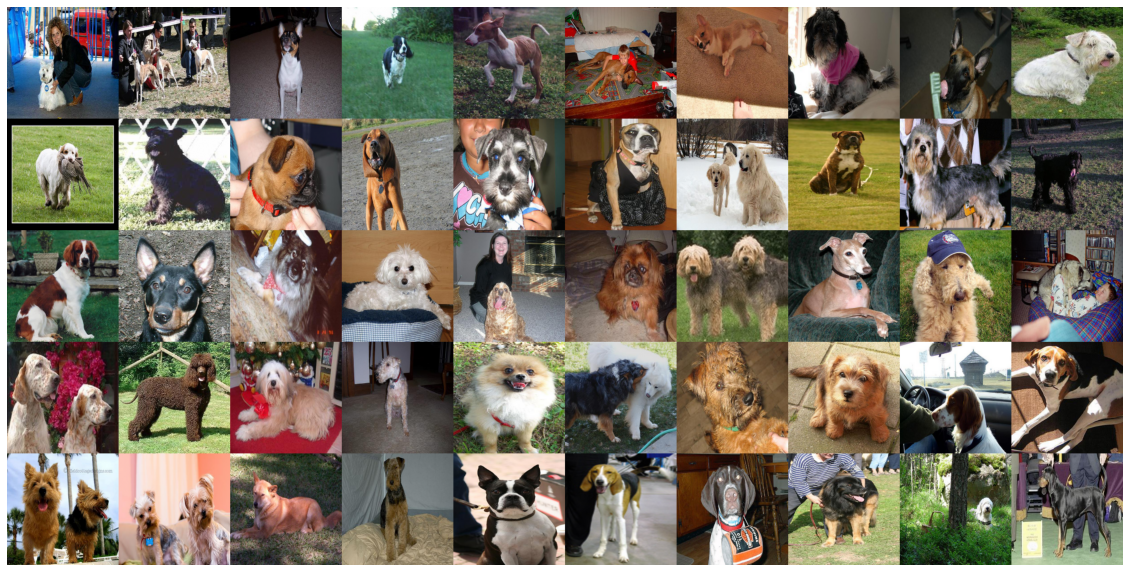

In [5]:
images, labels = get_images(train_data_dir)
plot_images(images)

## preprocessing

In [7]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,   
    validation_split=0.2,

)

valid_datagen = ImageDataGenerator(
    rescale= 1./255, 
    validation_split=0.2,
)

In [8]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='training',
    shuffle= True, 
    seed= 1337
) 

valid_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='validation',
    shuffle= True, 
    seed= 1337
)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [9]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)

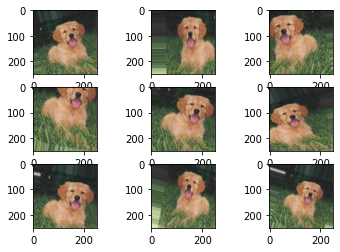

In [10]:
img = load_img('./Images/n02099601-golden_retriever/n02099601_5.jpg')
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0]
    plt.imshow(image)

plt.savefig('augmented_image.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

In [11]:
model = EfficientNetB0(input_shape=(img_width, img_height, channels), weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.25)(x)
x = Dense(120, activation='softmax')(x)

model = Model(inputs=model.input, outputs=x)
print(model.summary())

16809984/16804768 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
_____________________________

In [12]:
# with strategy.scope():
# model = get_model()
model.compile(optimizer= keras.optimizers.Adam(lr= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [13]:
import json
with open('model_config.json', 'w') as f:
    f.write(model.to_json())

In [27]:
checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=2,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [28]:
history = model.fit(
    train_generator, 
    epochs = 30,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    callbacks = callbacks,
    shuffle=True
)

Epoch 1/30
257/257 [==============================] - 292s 1s/step - loss: 4.2887 - accuracy: 0.1130 - val_loss: 1.5158 - val_accuracy: 0.6203

Epoch 00001: val_loss improved from inf to 1.51576, saving model to baseline_model.h5
Epoch 2/30
257/257 [==============================] - 274s 1s/step - loss: 1.4836 - accuracy: 0.5992 - val_loss: 0.8950 - val_accuracy: 0.7512

Epoch 00002: val_loss improved from 1.51576 to 0.89503, saving model to baseline_model.h5
Epoch 3/30
257/257 [==============================] - 271s 1s/step - loss: 0.9787 - accuracy: 0.7154 - val_loss: 0.7897 - val_accuracy: 0.7639

Epoch 00003: val_loss improved from 0.89503 to 0.78966, saving model to baseline_model.h5
Epoch 4/30
257/257 [==============================] - 270s 1s/step - loss: 0.7958 - accuracy: 0.7601 - val_loss: 0.7144 - val_accuracy: 0.7817

Epoch 00004: val_loss improved from 0.78966 to 0.71443, saving model to baseline_model.h5
Epoch 5/30
257/257 [==============================] - 270s 1s/step -